In [1]:
import sys
sys.path.append(r'/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter')

from vision.feature_extractor.feature_extractor import *
from MHS.F_model_training import *
from xgboost import XGBRegressor
import joblib
import xgboost
import pickle
from sklearn.model_selection import train_test_split

/home/fruitspec-lab/anaconda3/envs/FsCounter/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
import shap
import matplotlib.pyplot as plt

def plot_shap_summary(model, data, max_display=50):
    # Compute SHAP values
    explainer = shap.Explainer(model, data)
    shap_values = explainer(data)

    # Plot SHAP summary
    shap.summary_plot(shap_values, data, show=False, max_display=max_display)
    
    # Customize the plot
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
    return explainer, shap_values

def plot_waterfall(shap_values,sample_ind ,max_display=50):
    shap.plots.waterfall(shap_values[sample_ind], max_display=max_display)

In [3]:
use_best_study = True
remove_from_drop = ["foliage_fullness", "n_clust_arr_4", "cv2", "cv3", "cv4", "cv5", "q1", "q3"]
cfg = OmegaConf.load("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/model_config.yaml")
validate_output_path(cfg.output_folder)
final_cols, drop_final = get_rel_cols(cfg)
f_df = read_f_df(cfg)
features_df = read_data(cfg)
full_name_org = get_full_name(features_df)

drop_final = [col for col in drop_final if col not in remove_from_drop]

features_df_clean = clean_the_df(features_df, drop_final, cfg)
features_df_w_f = add_fs(features_df_clean, f_df)
full_name_clean = get_full_name(features_df_w_f)
dropped_obs = features_df[~full_name_org.isin(full_name_clean)]
dropped_obs.to_csv("dropped_obs.csv", index=False)

X_tr_lr, y, groups = get_X_y(features_df_w_f, cfg)
# X_train_trees = X_tr_lr[cfg.tree_cols]

In [4]:
def get_numerical_cols(df):
    return df.select_dtypes(include=[np.number]).columns.tolist()

def create_quantile_table(df):
    numerical_cols = get_numerical_cols(df)

    # Calculate quantiles for each numerical column
    quantiles = {
        'Min': df[numerical_cols].min(),
        'Q05': df[numerical_cols].quantile(0.05),
        'Q20': df[numerical_cols].quantile(0.2),
        'Q40': df[numerical_cols].quantile(0.4),
        'Q60': df[numerical_cols].quantile(0.6),
        'Q80': df[numerical_cols].quantile(0.8),
        'Q95': df[numerical_cols].quantile(0.95),
        'Max': df[numerical_cols].max()
    }

    # Create a new DataFrame to store the quantiles
    quantile_df = pd.DataFrame(quantiles)

    # Transpose the DataFrame to have numerical feature names as rows
    quantile_df = quantile_df.transpose()

    return quantile_df

# Assuming you have your DataFrame 'df' with mixed numerical and categorical columns
quantile_table = create_quantile_table(features_df_w_f)
quantile_table

,total_foliage,total_orange,volume,surface_area,avg_volume,foliage_fullness,center_width,center_perimeter,center_height,w_h_ratio,...,gli_skew,cv,cv2,cv3,cv4,cv5,lemon,mandarin,orange,F
Min,24.431535,0.034246,0.320014,1.433442,0.189619,0.759713,0.578238,0.376477,1.048285,0.050206,...,-0.912323,27.0,18.0,13.0,7.0,5.0,0.0,0.0,0.0,21.0
Q05,43.090882,0.411014,1.549798,2.217653,0.886466,0.803954,1.363278,1.003790,1.757537,0.059262,...,-0.370399,58.0,29.8,20.8,16.0,13.0,0.0,0.0,0.0,66.0
Q20,56.970640,0.764187,2.386949,2.789783,1.409232,0.834222,1.656259,1.317122,2.033791,0.066691,...,-0.183635,97.2,48.2,35.0,28.0,23.2,0.0,0.0,0.0,128.2
Q40,71.012196,1.331977,3.383523,3.257370,2.057604,0.881926,1.907595,1.584848,2.288174,0.071108,...,-0.023524,127.0,68.0,53.0,44.0,37.0,0.0,0.0,1.0,170.2
Q60,105.375995,1.969735,4.644758,3.649285,2.851215,0.916688,2.153044,1.890020,2.551456,0.075732,...,0.310914,173.2,98.2,80.0,67.0,59.6,0.0,0.0,1.0,225.6
Q80,166.197066,2.831494,8.246337,4.366628,5.595957,0.935834,2.779290,2.340293,2.912082,0.081405,...,0.915714,230.0,161.6,134.0,118.0,102.0,0.0,0.0,1.0,367.0
Q95,230.196233,4.621370,14.397438,5.373105,9.338059,0.951986,3.397529,3.173955,3.417770,0.089862,...,1.518566,405.4,281.6,235.8,203.4,184.0,1.0,1.0,1.0,789.6
Max,395.947729,6.560090,29.031209,7.519232,18.001082,0.970640,4.457204,5.624471,4.179912,0.104830,...,16.588658,957.0,713.0,572.0,467.0,391.0,1.0,1.0,1.0,1434.0


In [5]:
quantile_table["center_width"].round(2).values

array([0.58, 1.36, 1.66, 1.91, 2.15, 2.78, 3.4 , 4.46])

In [80]:
features_df_w_f["SUMGLD"] = features_df_w_f["full_name"].str.contains("SUMGLD")

In [81]:
features_df_w_f.groupby("SUMGLD")["foliage_fullness"].mean()

SUMGLD
False    0.923743
True     0.838258
Name: foliage_fullness, dtype: float64

In [76]:
features_df_w_f["foliage_fullness"]

0      0.955361
2      0.945313
3      0.936659
5      0.962402
7      0.942946
         ...   
810    0.880951
812    0.868156
814    0.855808
816    0.904776
818    0.899282
Name: foliage_fullness, Length: 460, dtype: float64

In [43]:
trees_results = pd.read_csv("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/models_3107/trees.csv", index_col = 0)
features_df_w_f["full_name"] = full_name_clean.iloc[:,0].values
trees_results = trees_results.merge(features_df_w_f.set_index("full_name")
                                    [["cv","cv2","cv3", "lemon", "mandarin", "orange"]], on ="full_name")
trees_results.to_csv("/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/models_3107/trees_w_cv.csv", index=False)

trees_results["cv/F"] = trees_results["cv"]/trees_results["F"]
trees_results["cv2/F"] = trees_results["cv2"]/trees_results["F"]
trees_results["cv3/F"] = trees_results["cv3"]/trees_results["F"]
trees_results.mean()

F                                271.102174
LassoPipe                        237.270877
XGBRegressor_local               255.368084
GradientBoostingRegressor        269.168810
RandomForestRegressor            299.012356
DecisionTreeRegressor            254.944565
HistGradientBoostingRegressor    261.158177
LGBMRegressor                    293.910878
cv                               178.791304
cv2                              111.560870
cv3                               89.684783
lemon                              0.054348
mandarin                           0.165217
orange                             0.780435
cv/F                               0.797534
cv2/F                              0.460826
cv3/F                              0.362630
dtype: float64

In [57]:
trees_results["block"] = trees_results["full_name"].apply(lambda x: x.split("_")[1])
trees_results.groupby("block")["cv/F", "cv2/F", "cv3/F", "orange", "lemon", "mandarin"].mean().sort_values("cv/F")

,cv/F,cv2/F,cv3/F,orange,lemon,mandarin
block,,,,,,
DWDBLE42,0.296599,0.171285,0.131077,0.0,1.0,0.0
DWDBCL46,0.425131,0.304172,0.253339,0.0,0.0,1.0
DWDBMN37,0.507306,0.386238,0.327519,0.0,0.0,1.0
DWDBLE33,0.545077,0.395553,0.333295,0.0,1.0,0.0
2004XXXX,0.567687,0.365406,0.295444,1.0,0.0,0.0
DWDBNC47,0.571370,0.414947,0.351500,1.0,0.0,0.0
Mandarin,0.575803,0.340325,0.256331,0.0,0.0,1.0
DWDBMN38,0.577412,0.439333,0.379568,0.0,0.0,1.0
DWDBMN16,0.579679,0.385979,0.324809,0.0,0.0,1.0


In [52]:
trees_results["fruit_type"] = trees_results[["orange", "lemon", "mandarin"]].apply(lambda x: ["orange", "lemon", "mandarin"][np.argmax(x)],axis = 1)
trees_results.groupby("fruit_type")["cv/F", "cv2/F", "cv3/F"].mean()


,cv/F,cv2/F,cv3/F
fruit_type,,,
lemon,0.675940,0.430871,0.351660
mandarin,0.620402,0.405531,0.325763
orange,0.843500,0.474617,0.371199


In [4]:
study_path = "/home/fruitspec-lab/FruitSpec/Code/roi/fsCounter/MHS/models_studies/study_xgb_notebook.pkl"

In [5]:
X_trees = X_tr_lr[[col for col in features_df.columns if col in X_tr_lr and col not in ["cv1","cv2","cv3","cv4","cv5"]]]

In [6]:
# X_train_trees, X_test_trees, y_train, y_test = train_test_split(X_trees, y, test_size=0.2, random_state=42)
X_train_trees = X_trees

In [7]:
study = joblib.load(study_path)
model_params = study.best_params
model_xgb = XGBRegressor(**model_params)
model_xgb.fit(X_train_trees, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1.0,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             eta=0.0011879929227077261, gamma=1.39, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             learning_rate=0.00118799298, max_delta_step=0, max_depth=7,
             min_child_weight=0.8400000000000001, missing=nan,
             monotone_constraints='()', n_estimators=1770, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=1.9908710348332748, reg_lambda=10.372033678167162,
             scale_pos_weight=1, subsample=0.8, tree_method='exact',
             validate_parameters=1, verbosity=None)

 97%|=================== | 448/460 [00:23<00:00]       

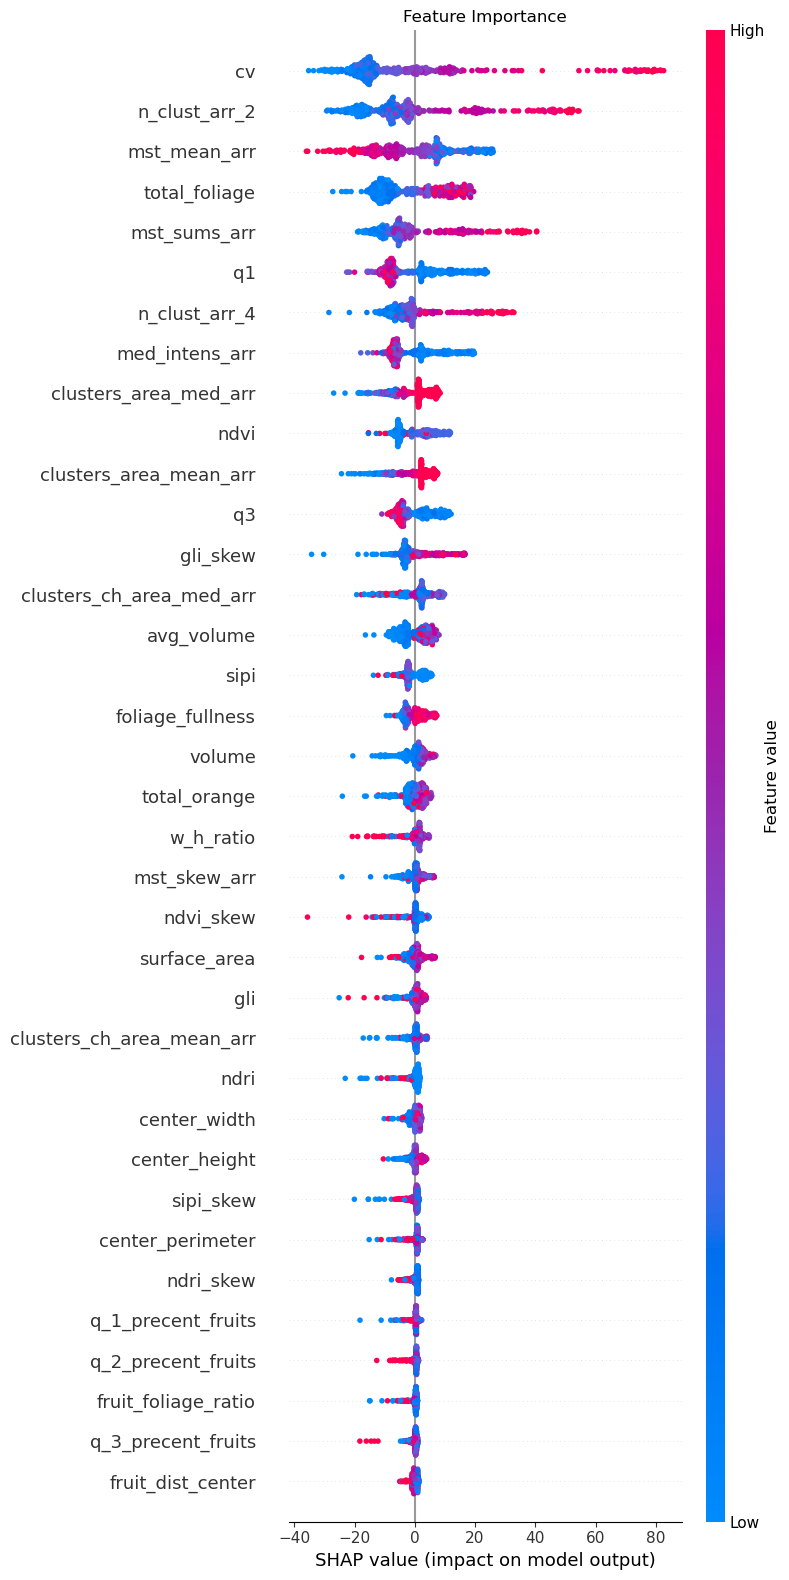

In [8]:
explainer, shap_values = plot_shap_summary(model_xgb, X_train_trees)

In [9]:
# explainer, shap_values = plot_shap_summary(model_xgb, X_test_trees)

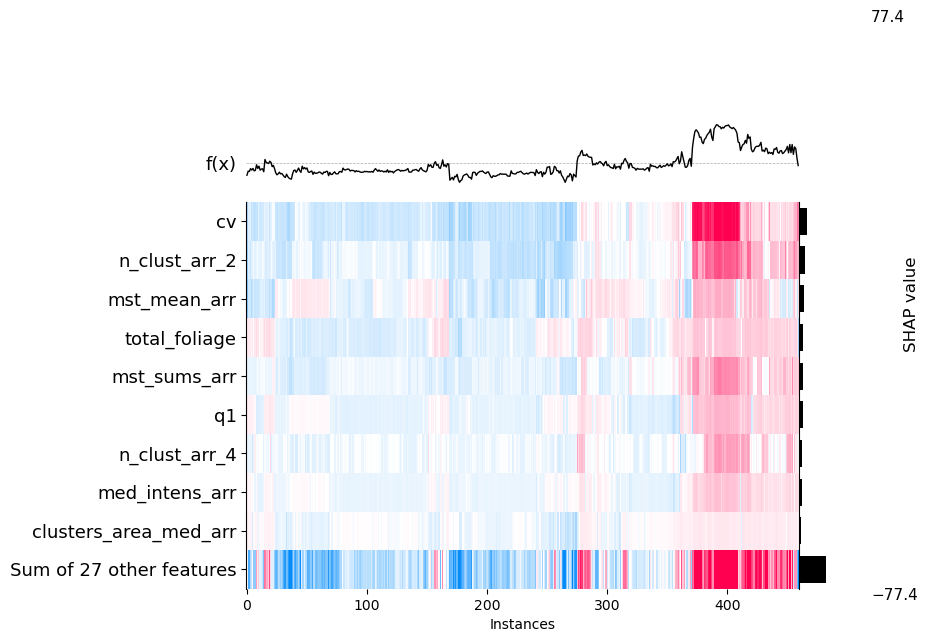

In [10]:
shap.plots.heatmap(shap_values,max_display=10)

In [11]:
preds = model_xgb.predict(X_train_trees)
errors = (preds - y)/ y

In [12]:
full_name_clean = pd.DataFrame(full_name_clean).reset_index(drop=True)
full_name_clean["err"] = errors

In [13]:
full_name_clean.sort_values("err")

,customer,err
40,DEWAGD_DWDBMN37_R5_S1_T1,-0.581774
41,DEWAGD_DWDBMN37_R5_S2_T1,-0.563245
260,PROPAL_Mandarin_R48_S2_T1,-0.552773
155,DEWAGD_DWDBLE33_R35_S1_T1,-0.550580
413,SHANIR_SUMGLD_R7_S1_T23,-0.548264
...,...,...
226,PROPAL_FUKUMOTO_R44_S1_T1,1.315581
287,SHANIR_SUMGLD_R11_S1_T5,1.376968
398,SHANIR_SUMGLD_R6_S1_T30,1.454526
371,SHANIR_SUMGLD_R5_S1_T17,1.625316


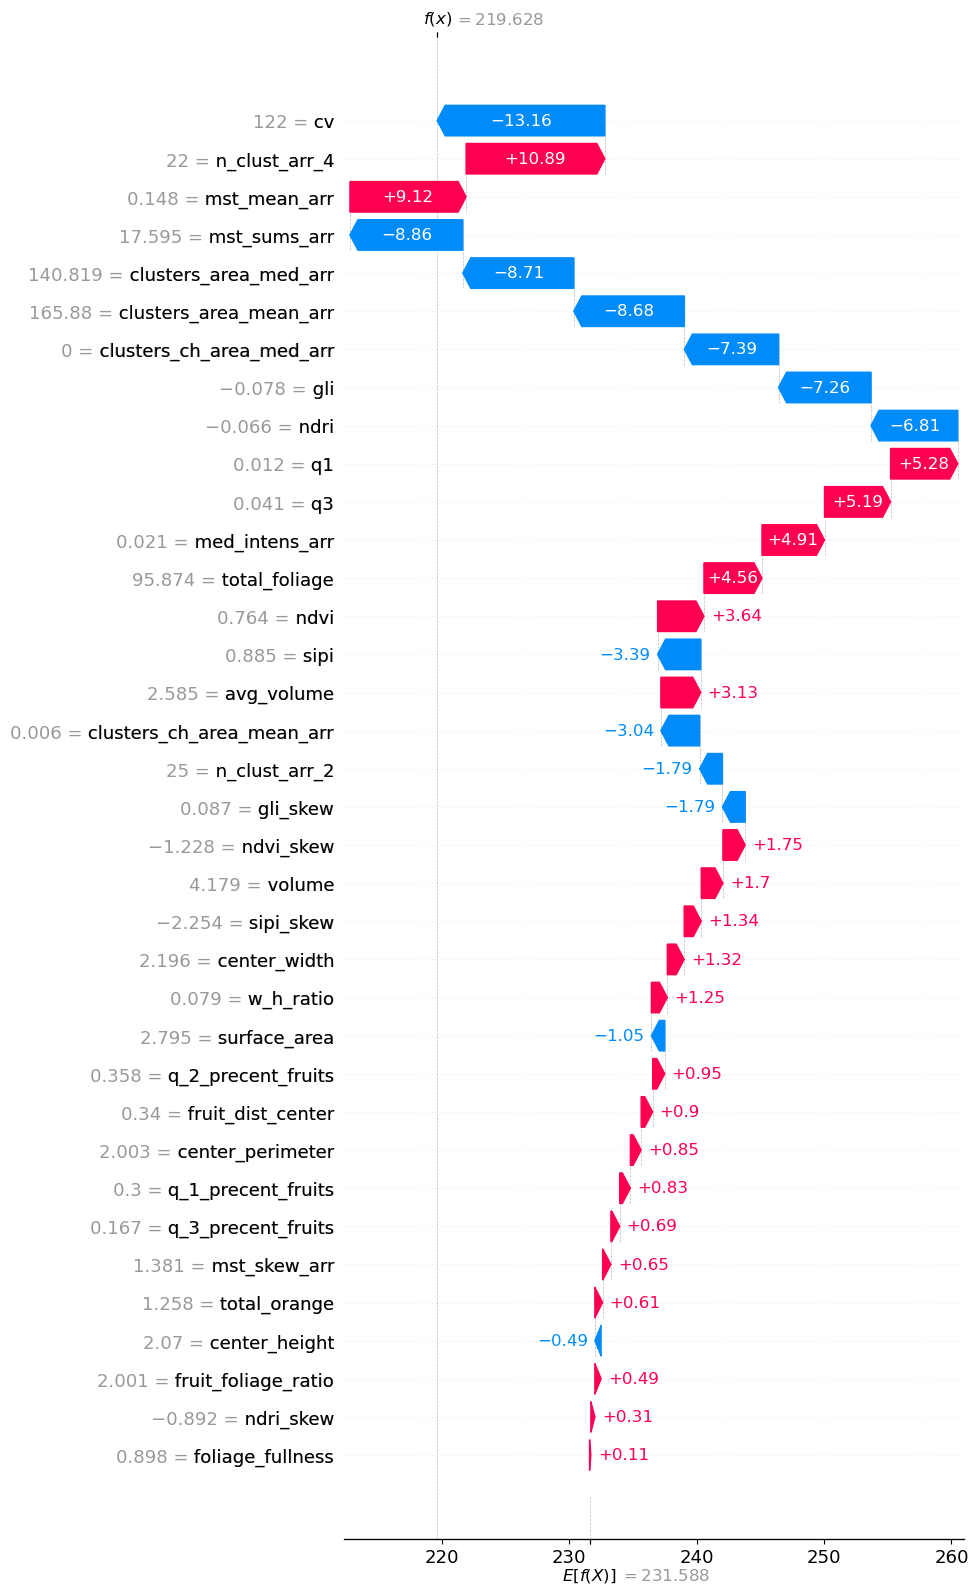

In [17]:
observation_of_intrest = "PROPAL_2004XXXX_R29_S1_T1"
index = np.where(full_name_clean["customer"] == observation_of_intrest)[0][0]
plot_waterfall(shap_values,index ,max_display=50)